**Offline Verification**

Reference code: https://github.com/vermavinay982/sign-verification-siamese-net-pytorch/blob/main/SigNet_Siamese_Network.ipynb

https://datahacker.rs/019-siamese-network-in-pytorch-with-application-to-face-similarity/

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
training_dir = "/content/drive/MyDrive/SignatureVerificationCylab/MCYT_from_DeepSign_Images"
# training_csv = "/content/drive/MyDrive/SignatureVerificationCylab/train_data.csv"
testing_csv = "/content/drive/MyDrive/SignatureVerificationCylab/test_data.csv"
training_csv = "/content/drive/MyDrive/SignatureVerificationCylab/training_small.csv"
testing_csv = "/content/drive/MyDrive/SignatureVerificationCylab/testing_small.csv"
testing_dir = training_dir
batch_size = 32
epochs = 6



In [ ]:
# import the necessary libraries
import numpy as np
import pandas as pd


train_df = pd.read_csv(training_csv)
train_df

,filename1,filename2,label
0,u0001_g_0100v01.jpg,u0001_g_0100v00.jpg,1
1,u0001_g_0100v01.jpg,u0001_g_0100v02.jpg,1
2,u0001_g_0100v01.jpg,u0001_g_0100v11.jpg,1
3,u0001_g_0100v01.jpg,u0001_g_0100v12.jpg,1
4,u0001_g_0100v01.jpg,u0001_g_0100v05.jpg,1
...,...,...,...
18495,u0199_g_0403v22.jpg,u0199_s_0403f22.jpg,0
18496,u0199_g_0403v22.jpg,u0199_s_0403f11.jpg,0
18497,u0199_g_0403v22.jpg,u0199_s_0403f21.jpg,0
18498,u0199_g_0403v22.jpg,u0199_s_0403f13.jpg,0


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.utils
# import config
#from utils import imshow, show_plot
# from contrastive import ContrastiveLoss
import torchvision
from torch.autograd import Variable
from PIL import Image
import PIL.ImageOps
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import numpy as np
import torch.nn.functional as F
import math




In [ ]:
def imshow(img, text=None, should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(
            75,
            8,
            text,
            style="italic",
            fontweight="bold",
            bbox={"facecolor": "white", "alpha": 0.8, "pad": 10},
        )
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def show_plot(iteration, loss):
    plt.plot(iteration, loss)
    plt.show()

In [ ]:
torch.acos(torch.tensor(0))

tensor(1.5708)

In [ ]:
# train the model'

def compute_angular_similarity(vector1, vector2):
    """
    Computes the angular similarity between two vectors using cosine similarity in PyTorch.
    """
    cosine_sim = torch.nn.functional.cosine_similarity(vector1, vector2)
    angular_sim = 1 - torch.acos(cosine_sim) / (math.pi)
    return angular_sim

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, target):
        # Calculate cosine similarity between the output embeddings
        angular_similarity = compute_angular_similarity(output1, output2)
        print(angular_similarity)

        # Calculate contrastive loss
        loss_contrastive = torch.mean((1 - target) * torch.pow(angular_similarity, 2) +
                                      target * torch.pow(torch.clamp(self.margin - angular_similarity, min=0.0), 2))

        return loss_contrastive

In [ ]:
#Test criterion
criterion = ContrastiveLoss()
tensor1 = torch.tensor([[1.0, 2.0],[1, 2]])
tensor2 = torch.tensor([[1.0, 2.0],[1, 2]])
print("similar with target 1", criterion (tensor1,tensor2, 1))
print("similar with target 0", criterion (tensor1,tensor2, 0))

tensor1 = torch.tensor([[-1.0, -2.0],[-1, -2]])
tensor2 = torch.tensor([[1.0, 2.0],[1, 2]])
print("disimilar with target 1",criterion (tensor1,tensor2, 1))
print("disimilar with target 0",criterion (tensor1,tensor2, 0))

tensor([0.9999, 0.9999])
similar with target 1 tensor(1.2080e-08)
tensor([0.9999, 0.9999])
similar with target 0 tensor(0.9998)
tensor([0.0001, 0.0001])
disimilar with target 1 tensor(0.9998)
tensor([0.0001, 0.0001])
disimilar with target 0 tensor(1.2094e-08)


tensor(1.)

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    "Contrastive loss function"

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        cos = torch.nn.CosineSimilarity()
        cosine_similarity = cos(output1, output2)

        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2)
            + (label)
            * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )

        return loss_contrastive

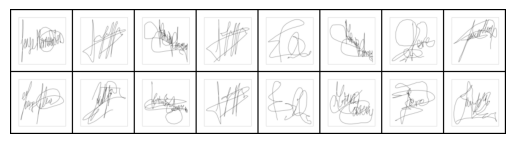

[[0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]]
Number of batches is: 579


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# preprocessing and loading the dataset
class SiameseDataset:
    def __init__(self, training_csv=None, training_dir=None, transform=None):
        # used to prepare the labels and images path
        self.train_df = pd.read_csv(training_csv)
        self.train_df.columns = ["image1", "image2", "label"]
        self.train_dir = training_dir
        self.transform = transform

    def __getitem__(self, index):

        # getting the image path
        image1_path = os.path.join(self.train_dir, self.train_df.iat[index, 0])
        image2_path = os.path.join(self.train_dir, self.train_df.iat[index, 1])

        # Loading the image
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        img0 = img0.convert("L")
        img1 = img1.convert("L")

        # Apply image transformations
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return (
            img0,
            img1,
            torch.from_numpy(
                np.array([int(self.train_df.iat[index, 2])], dtype=np.float32)
            ),
        )

    def __len__(self):
        return len(self.train_df)


train_transforms = torchvision.transforms.Compose([
            transforms.Resize((105, 105)),
            torchvision.transforms.ToTensor(),
            # torchvision.transforms.Normalize(mean=(0.485),
            #                                  std=(0.229)),

        ])
valid_transforms = train_transforms

# Load the the dataset from raw image folders
siamese_dataset = SiameseDataset(
    training_csv,
    training_dir,
    transform=train_transforms
)

# siamese_dataset = SiameseDataset(
#     training_csv,
#     training_dir,
#     transform=transforms.Compose(
#         [transforms.Resize((105, 105)), transforms.ToTensor()]
#     ),
# )





# Viewing the sample of images and to check whether its loading properly
vis_dataloader = DataLoader(siamese_dataset, shuffle=True, batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]), 0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())


# Load the dataset as pytorch tensors using dataloader
train_dataloader = DataLoader(
    siamese_dataset, shuffle=True, num_workers=8, batch_size=batch_size
)

print(f"Number of batches is: {len(train_dataloader)}")



# model = SiameseNetwork().cuda()
# params = torch.load('/content/drive/MyDrive/SignFaker/model.pt')
# # print(params)
# model.load_state_dict(params)



In [ ]:
def initialize_weights_he(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            # He initialization for ReLU activation
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)

In [ ]:
# create a siamese network
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.in_channels = 1
        self.out_classes = 2


        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(self.in_channels, 96, kernel_size=11, stride=1),
            nn.GELU(),
            nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.GELU(),
            nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.GELU(),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.GELU(),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),
        )

        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(30976, 1024),
            nn.GELU(),
            nn.Dropout2d(p=0.5),
            nn.Linear(1024, 128),
            nn.GELU(),
            nn.Linear(128, self.out_classes),
        )

    def forward_once(self, x):
        # Forward pass
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2


In [ ]:
# # create a siamese network
# class SiameseNetwork(nn.Module):
#     def __init__(self):
#         super(SiameseNetwork, self).__init__()

#         self.in_channels = 1
#         self.out_classes = 2


#         # Setting up the Sequential of CNN Layers
#         self.cnn1 = nn.Sequential(
#             nn.Conv2d(self.in_channels, 96, kernel_size=11, stride=1),
#             nn.ReLU(inplace=True),
#             nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2),
#             nn.MaxPool2d(3, stride=2),
#             nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
#             nn.ReLU(inplace=True),
#             nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2),
#             nn.MaxPool2d(3, stride=2),
#             nn.Dropout2d(p=0.3),
#             nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(3, stride=2),
#             nn.Dropout2d(p=0.3),
#         )

#         # Defining the fully connected layers
#         self.fc1 = nn.Sequential(
#             nn.Linear(30976, 1024),
#             nn.ReLU(inplace=True),
#             nn.Dropout2d(p=0.5),
#             nn.Linear(1024, 128),
#             nn.ReLU(inplace=True),
#             nn.Linear(128, self.out_classes),
#         )

#     def forward_once(self, x):
#         # Forward pass
#         output = self.cnn1(x)
#         output = output.view(output.size()[0], -1)
#         output = self.fc1(output)
#         return output

#     def forward(self, input1, input2):
#         # forward pass of input 1
#         output1 = self.forward_once(input1)
#         # forward pass of input 2
#         output2 = self.forward_once(input2)
#         return output1, output2


In [ ]:
#

In [ ]:
# Declare Siamese Network
net = SiameseNetwork().cuda()

initialize_weights_he(net)
# Decalre Loss Function
criterion = ContrastiveLoss()

learning_rate = 1e-4
T_max = 10  # Number of epochs to reach the minimum learning rate
eta_min = 0.00001  # Minimum learning rate

# Declare Optimizer
# optimizer = torch.optim.RMSprop(net.parameters(), lr=1e-4, alpha=0.99, eps=1e-8, weight_decay=0.0005, momentum=0.9)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.0005)

# Define the CosineAnnealingLR scheduler
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)


In [ ]:
# # Declare Siamese Network
# net = SiameseNetwork().cuda()
# # Decalre Loss Function

# # Define the cosine embedding loss function
# loss_fn = nn.CosineEmbeddingLoss()

# # Define your optimizer
# optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [ ]:
def compute_accuracy(output1, output2, target, threshold=0.7):
    # Calculate cosine similarity between the output embeddings
    # cos_similarity = abs((output1, output2))
    angular_similarity = compute_angular_similarity(output1, output1)

    # Predict similarity (1) if cosine similarity is above threshold, else predict dissimilarity (0)
    predictions = (angular_similarity > threshold).float()


    # Compare predictions with target labels and calculate accuracy
    # correct = (predictions == target).float().mean().item()
    correct = (predictions == target).float()

    correct = torch.mean(correct, dim=1)

    return correct


def train():
    loss = []
    accuracies = []
    counter = 0
    correct = 0
    total = 0
    num_epochs = []
    total = 0
    # correct_pred = 0
    # iteration_number = 0
    # with torch.enable_grad():
    for epoch in range(1, epochs):
        for i, data in enumerate(train_dataloader, 0):
            img0, img1, label = data

            img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
            optimizer.zero_grad()
            output1, output2 = net(img0, img1)
            loss_contrastive = criterion(output1, output2, label)
            learning_rate = optimizer.param_groups[0]['lr']
            # Access the model weights during training
            model_weights = net.state_dict()

            # Print the model weights
            print(model_weights)
            print(f"loss {loss_contrastive}, learning rate {learning_rate}")
            torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
            loss_contrastive.backward()
            optimizer.step()

            #Update with total number of correct predictions in a batch
            correct += sum(compute_accuracy(output1, output2, label))
            #total number images in that batch
            total += batch_size

        accuracy = (correct / total)*100
        num_epochs.append(epoch)
        accuracies.append(accuracy.item())
        loss.append(loss_contrastive.item())

        print(f"Epoch: {epoch} Current loss: {loss_contrastive.item()} Accuracy: {accuracy}\n")


    show_plot(num_epochs, loss)
    show_plot(num_epochs, accuracies)
    return net


# set the device to cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = train()
torch.save(model.state_dict(), "/content/drive/MyDrive/SignatureVerificationCylab/hw_model.pt")
print("Model Saved Successfully")


cuda


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Streaming output truncated to the last 5000 lines.
          [-3.3775e-02,  2.3931e-02, -5.1654e-04]],

         [[ 6.8122e-03, -1.5733e-03,  6.5018e-03],
          [-3.1174e-05, -8.3257e-03,  3.0528e-02],
          [ 5.2550e-03,  1.1200e-02,  5.9249e-03]],

         ...,

         [[ 1.2558e-02,  2.8495e-02,  1.2504e-02],
          [-6.7760e-03,  1.5174e-02,  9.2896e-03],
          [-4.4449e-03,  9.4930e-03, -5.0149e-02]],

         [[ 1.6897e-02, -1.6239e-02,  5.6951e-03],
          [-1.1579e-02, -5.5295e-02, -2.3138e-02],
          [ 1.7282e-02, -1.5710e-02, -2.0657e-02]],

         [[-3.7725e-02, -2.7372e-02,  2.5726e-02],
          [ 1.3885e-03,  2.0748e-03, -1.5106e-02],
          [-2.4931e-03,  4.9753e-03, -3.1234e-02]]],


        [[[ 1.7890e-02, -1.2593e-02, -7.1791e-03],
          [ 1.1986e-03,  4.4512e-03,  5.5729e-04],
          [ 2.6442e-02,  3.0513e-03, -4.8422e-03]],

         [[-1.8397e-02, -6.1299e-02,  2.5711e-03],
          [ 4.0605e-02,  4.5341e-02,  1.5171e-03],
  

KeyboardInterrupt: ignored

In [ ]:
# Load the test dataset
test_dataset = SiameseDataset(
    training_csv=testing_csv,
    training_dir=testing_dir,
    transform=transforms.Compose(
        [transforms.Resize((105, 105)), transforms.ToTensor()]
    ),
)

test_dataloader = DataLoader(test_dataset, num_workers=6, batch_size=1, shuffle=True)

count = 0
orig = []
fakes = []
for i, data in enumerate(test_dataloader, 0):
    x0, x1, label = data
    concat = torch.cat((x0, x1), 0)
    output1, output2 = model(x0.to(device), x1.to(device))

    # eucledian_distance = F.pairwise_distance(output1, output2)
    # cos = torch.nn.CosineSimilarity()
    # cosine_similarity = cos(output1, output2)
    angular_similarity = compute_angular_similarity(output1, output1)

    if label == torch.FloatTensor([[0]]):
        label = "Original Pair Of Signature"
        orig += [angular_similarity.item()]
    else:
        fakes += [angular_similarity.item()]
        label = "Forged Pair Of Signature"

    if count < 20:
      imshow(torchvision.utils.make_grid(concat), f'Dissimilarity: {angular_similarity.item():.2f} Label: {label}')

    count+=1

    # imshow(torchvision.utils.make_grid(concat))
    # print("Predicted Eucledian Distance:", eucledian_distance.item())
    # print("Actual Label:", label)
    # count = count + 1
    # if count == 10:
    #     break
print(orig)
print(fakes)

Visualization of embeddings

Reference: https://github.com/AdrianUng/keras-triplet-loss-mnist/blob/master/Triplet_loss_KERAS_semi_hard_from_TF.ipynb

In [ ]:
test_df = pd.read_csv(testing_csv)

In [ ]:
test_df

,filename1,filename2,label
0,u0200_g_0404v00.jpg,u0200_g_0404v01.jpg,0
1,u0200_g_0404v00.jpg,u0200_g_0404v15.jpg,0
2,u0200_g_0404v00.jpg,u0200_g_0404v08.jpg,0
3,u0200_g_0404v00.jpg,u0200_g_0404v16.jpg,0
4,u0200_g_0404v00.jpg,u0200_g_0404v12.jpg,0
...,...,...,...
5545,u0205_g_0409v23.jpg,u0205_s_0409f21.jpg,1
5546,u0205_g_0409v23.jpg,u0205_s_0409f23.jpg,1
5547,u0205_g_0409v23.jpg,u0205_s_0409f19.jpg,1
5548,u0205_g_0409v23.jpg,u0205_s_0409f18.jpg,1


In [ ]:
df = pd.concat([test_df["filename1"], test_df["filename2"]], axis=1, keys=["filename"])

In [ ]:
test_df.shape

(5550, 3)

In [ ]:
df.shape

(5550,)

In [ ]:
df

,filename
0,u0200_g_0404v00.jpg
1,u0200_g_0404v00.jpg
2,u0200_g_0404v00.jpg
3,u0200_g_0404v00.jpg
4,u0200_g_0404v00.jpg
...,...
5545,u0205_g_0409v23.jpg
5546,u0205_g_0409v23.jpg
5547,u0205_g_0409v23.jpg
5548,u0205_g_0409v23.jpg


In [ ]:
# from sklearn.decomposition import PCA

# # Visualizing the effect of embeddings -> using PCA!

# no_of_components = 2

# x_embeddings =
# dict_embeddings = {}
# dict_gray = {}
# test_class_labels = np.unique(np.array(y_test))

# pca = PCA(n_components=no_of_components)
# decomposed_embeddings = pca.fit_transform(x_embeddings)
# #     x_test_reshaped = np.reshape(x_test, (len(x_test), 28 * 28))
# decomposed_gray = pca.fit_transform(x_embeddings_before_train)

# fig = plt.figure(figsize=(16, 8))
# for label in test_class_labels:
#     decomposed_embeddings_class = decomposed_embeddings[y_test == label]
#     decomposed_gray_class = decomposed_gray[y_test == label]

#     plt.subplot(1,2,1)
#     plt.scatter(decomposed_gray_class[::step,1], decomposed_gray_class[::step,0],label=str(label))
#     plt.title('before training (embeddings)')
#     plt.legend()

#     plt.subplot(1,2,2)
#     plt.scatter(decomposed_embeddings_class[::step, 1], decomposed_embeddings_class[::step, 0], label=str(label))
#     plt.title('after @%d epochs' % epochs)
#     plt.legend()

# plt.show()

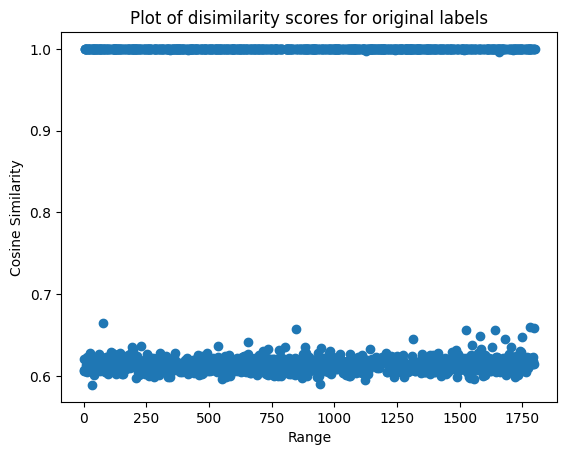

In [ ]:
plt.title("Plot of disimilarity scores for original labels")
plt.xlabel("Range")
plt.ylabel("Cosine Similarity")
plt.scatter([i for i in range(len(orig))], orig)

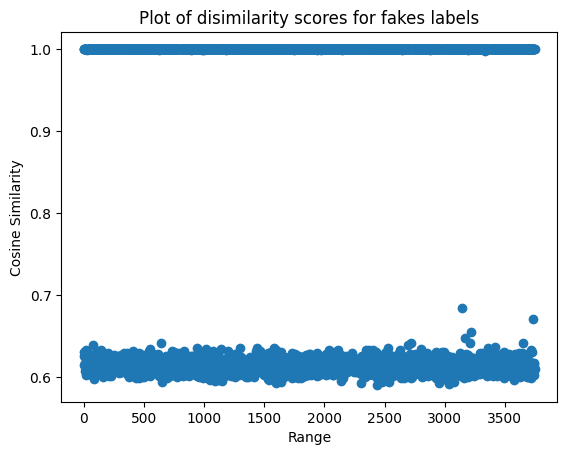

In [ ]:
plt.title("Plot of disimilarity scores for fakes labels")
plt.xlabel("Range")
plt.ylabel("Cosine Similarity")
plt.scatter([i for i in range(len(fakes))], fakes)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !ls /content/drive/MyDrive/SignFaker